In [18]:
# Imports

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# tensorflow version

tf.__version__

'1.14.0'

In [20]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

x_train= X_train.astype(np.float32)/255.
x_test = X_test.astype(np.float32)/255.

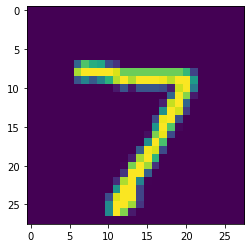

In [21]:
plt.imshow(X_test[0]);

In [22]:
learning_rate = 0.01
epochs = 200
batch_size = 256

n_inputs = np.power(x_train.shape[1], 2)
layers = [n_inputs, 256, 128, 64, 10]
#layers = [n_inputs, 64, 10]

In [23]:
x_train = x_train.reshape(-1, n_inputs)
x_test = x_test.reshape(-1, n_inputs)

y_train = pd.get_dummies(Y_train).values
y_test = pd.get_dummies(Y_test).values

In [24]:
X = tf.placeholder(tf.float32, [None, n_inputs])

Y = tf.placeholder(tf.float32, [None, 10])

In [25]:
def init_weights(layers):
    n_layers = len(layers)

    w = {"W"+str(i+1): tf.Variable(tf.random_normal((layers[i], layers[i+1])), \
                                   name="W"+str(i+1), dtype=tf.float32) \
                                   for i in range(n_layers-1)}
    
    b = {"b"+str(i+1): tf.Variable(tf.random_normal([1, layers[i+1]]), \
                                   name="b"+str(i+1), dtype=tf.float32) \
                                   for i in range(n_layers-1)}
    
    return w, b

weights, bias = init_weights(layers)

In [26]:
def encoder(X, weights, bias):
    n_layers = len(weights.keys())
    
    for i in range(n_layers): # tf.nn.relu is not applyed to output layer
        X = tf.add(tf.matmul(X, weights["W"+str(i+1)]), bias["b"+str(i+1)])
        if i != n_layers-1:
            X = tf.nn.relu(X)
        
    return X

In [27]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels= Y, \
                                                      logits=encoder(X, weights,bias)))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
opt = optimizer.minimize(loss)

In [28]:
LOSS_train = []
LOSS_test = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for epochs in range(epochs):
        train_index = np.random.choice(X_train.shape[0], size=batch_size)
        test_index = np.random.choice(X_test.shape[0], size=batch_size)
        
        _, loss_train = sess.run([opt, loss], feed_dict={X: x_train[train_index], Y: y_train[train_index]})
        _, loss_test = sess.run([opt, loss], feed_dict={X: x_test[test_index], Y: y_test[test_index]})
        
        LOSS_train.append(loss_train)
        LOSS_test.append(loss_test)
        
    W_trained, b_trained = sess.run([weights, bias])
    
    Y_pred = sess.run(tf.arg_max(tf.nn.softmax(encoder(X, W_trained, b_trained)), 1), \
                      feed_dict={X: x_test})

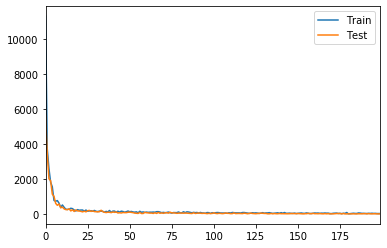

In [29]:
l = pd.DataFrame(np.transpose([LOSS_train, LOSS_test]), columns=["Train", "Test"])
l.plot();

In [30]:
W_trained, b_trained

({'W1': array([[-1.1528716 ,  0.34312117,  0.7374744 , ...,  0.18877423,
          -1.1975651 ,  0.4394971 ],
         [ 0.2927339 ,  0.8994163 ,  1.1965437 , ...,  0.82665855,
           0.69303256, -0.94829166],
         [ 1.2524223 , -1.4657584 , -1.3423458 , ...,  0.12946804,
          -1.1662334 ,  0.17988063],
         ...,
         [ 1.6344516 ,  0.3334427 , -0.19318794, ..., -0.8168933 ,
           0.30219123, -0.9914203 ],
         [ 0.48430794,  2.5653186 , -0.03602663, ..., -1.4760014 ,
           0.20263349,  1.2539982 ],
         [-1.4826049 ,  0.04173022,  0.15835321, ..., -0.6490012 ,
          -1.0214584 , -0.17117436]], dtype=float32),
  'W2': array([[-0.5522316 , -2.2886357 , -2.7004607 , ...,  0.8122453 ,
          -0.5104504 , -0.87982845],
         [ 1.3027982 , -0.5018795 , -1.8420142 , ..., -0.08669739,
          -0.03077392,  0.37302864],
         [-0.40826058, -0.5591485 ,  0.3148305 , ..., -1.6157079 ,
          -0.65671504, -2.14243   ],
         ...,
       

In [31]:
Y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [32]:
Y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [34]:
acc = (Y_pred == Y_test).sum()/Y_test.shape[0]
acc

0.9482